<a href="https://colab.research.google.com/github/matthiaszeller/dl-project/blob/main/Hybrid_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

# dataset build

In [2]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz

--2021-03-17 19:08:02--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-17 19:08:02--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [           <=>      ]  33.20M  14.7MB/s    in 2.3s    

2021-03-17 19:08:05 (14.7 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]



In [3]:
!tar -xf MNIST.tar.gz


In [4]:
!ls MNIST/processed/

test.pt  training.pt


In [5]:
######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size = 2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes

######################################################################

def generate_pair_sets(nb):

    train_set = datasets.MNIST('', train = True, download = True)
    train_input = train_set.data.view(-1, 1, 28, 28).float()
    train_target = train_set.targets

    test_set = datasets.MNIST('', train = False, download = True)
    test_input = test_set.data.view(-1, 1, 28, 28).float()
    test_target = test_set.targets

    return mnist_to_pairs(nb, train_input, train_target) + \
           mnist_to_pairs(nb, test_input, test_target)

######################################################################

In [13]:
train_input , train_target , train_classes , test_input , test_target , test_classes = generate_pair_sets(1000)

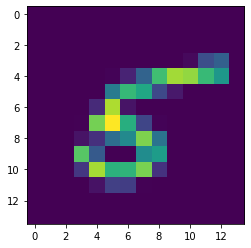

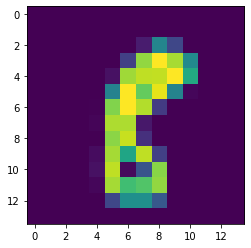

train shape : torch.Size([1000, 2, 14, 14])


In [14]:
plt.imshow( train_input[0][0].numpy() ) 
plt.show()
plt.imshow( train_input[0][1].numpy() ) 
plt.show()
print(f'train shape : {train_input.shape}')

In [16]:
train_dataset = TensorDataset(train_input,train_target , train_classes)
train_dataloader = DataLoader(train_dataset , batch_size=100)

test_dataset = TensorDataset(test_input,test_target , test_classes)
test_dataloader = DataLoader(test_dataset , batch_size=100)


In [9]:
for el in train_dataloader:
  # image , target, classes
  print(el[0].shape, el[1].shape, el[2].shape)
  break

torch.Size([100, 2, 14, 14]) torch.Size([100]) torch.Size([100, 2])


# Models

In [10]:
class FullyDenseNet(nn.Module):
    def __init__(self):
        super(FullyDenseNet, self).__init__()

        self.fc1 = nn.Linear(2*14*14, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, 1)

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.fc1(x) )
        x = torch.relu( self.fc2(x) )
        x = torch.relu( self.fc3(x) )
        x = torch.relu( self.fc4(x) )
        x = self.fc5(x)
        return torch.sigmoid(x)

## CNN Model 3 : Weight Sharing + AL Combined

In [26]:
class CNN_Model3(nn.Module):
    def __init__(self):
        super(CNN_Model3, self).__init__()

        # Network basis: common for all losses
        # 14 * 14 = 196
        self.fc1_im1 = nn.Linear(14*14, 100)
        self.fc1_im2 = nn.Linear(14*14, 100)
        
        self.fc2_im1 = nn.Linear(100, 50)
        self.fc2_im2 = nn.Linear(100, 50)
        
        # Auxiliary networks
        self.fc3 = nn.Linear(50, 10)
        
        # Main task
        self.fc4 = nn.Linear(2*50, 10)
        self.fc5 = nn.Linear(10, 1)

    def forward(self, x):
        im1 = nn.Flatten()(x[:, 0, :, :])
        im2 = nn.Flatten()(x[:, 1, :, :])
        
        im1 = torch.relu(self.fc1_im1(im1))
        im2 = torch.relu(self.fc1_im2(im2))
        
        im1 = torch.relu(self.fc2_im1(im1))
        im2 = torch.relu(self.fc2_im2(im2))
        
        # Main task
        common = torch.cat((im1, im2), dim=1)
        common = torch.relu(self.fc4(common))
        common = self.fc5(common)
        common = torch.sigmoid(common)
        
        # Auxiliary networks
        im1 = self.fc3(im1)
        im1 = F.softmax(im1, dim=0)
        
        im2 = self.fc3(im2)
        im2 = F.softmax(im2, dim=0)
        
        return common, im1, im2

# Train tools

In [18]:
def custom_loss(output, target, classes, lambda_=1.0):
  """
  Custom loss for network with auxiliary losses. The total loss is a combination
  of the loss of the main task (binary cross entropy) and the negative log likelihood
  for the two auxiliary tasks. Importance of auxiliary losses is controlled by
  the `lambda_` hyperparameter.
  """
  main, im1, im2 = output

  main_loss = F.binary_cross_entropy(main.flatten(), target)
  aux_loss_1 = F.nll_loss(im1, classes[:, 0])
  aux_loss_2 = F.nll_loss(im2, classes[:, 1])

  return main_loss + lambda_ * (aux_loss_1 + aux_loss_2)

In [19]:
def handle_loss(criterion):
  """
  Handle the fact that the network with auxiliary loss has three-item tuple output,
  which needs to be treated separately to compute the loss and the accuracy.
  """
  if criterion is not custom_loss:
    internal_criterion = lambda output, target, _: criterion(output.flatten(), target)
    compute_acc = lambda output, target: (target == torch.round(output.flatten()) ).sum().item()
  else:
    internal_criterion = criterion
    compute_acc = lambda output, target: (target == torch.round(output[0].flatten()) ).sum().item()
    
  return internal_criterion, compute_acc

In [20]:
def train_epoch(network_ , optimizer_ , criterion = F.binary_cross_entropy ):
  internal_criterion, compute_acc = handle_loss(criterion)
    
  loss_tot = []
  acc_tot = []
  network_.train()
  for batch_idx, (data, target , classes ) in enumerate(train_dataloader):
    optimizer_.zero_grad()
    output = network_(data)
    loss = internal_criterion(output, target.to(torch.float32), classes)
    loss.backward()
    optimizer_.step()

    loss_tot.append(loss.item())
    acc_tot.append( compute_acc(output, target) )
  
  return torch.FloatTensor(loss_tot).mean().item() , torch.FloatTensor(acc_tot).mean().item()/100.0

In [21]:
def test(network_ , criterion_ = F.binary_cross_entropy):
  internal_criterion, compute_acc = handle_loss(criterion_)

  network_.eval()
  test_loss = 0
  acc = 0

  with torch.no_grad():
    for data, target , classes in test_dataloader:
      output = network_(data)
      test_loss += internal_criterion(output, target.to(torch.float32), classes)
      acc += compute_acc(output, target)

  test_loss /= len(test_dataloader)
  acc /= len(test_dataloader)
  return test_loss , acc/100.0

In [22]:
def train(network_ , optimizer_ , criterion_ = F.binary_cross_entropy ,epoch_nb = 30,   debug_ = True):

  tot_train_loss = []
  tot_train_acc = []
  tot_test_loss = []
  tot_test_acc = []


  for epoch in range(epoch_nb):
    train_loss , train_acc = train_epoch(network_ , optimizer_ , criterion_)
    test_loss , test_acc = test(network_ , criterion_)

    tot_train_loss.append(train_loss)
    tot_train_acc.append(train_acc)
    tot_test_loss.append(test_loss)
    tot_test_acc.append(test_acc)

    if(debug_):
      print(epoch, f'{train_loss:.4}\t{train_acc:.4}\t{test_loss:.4}\t{test_acc:.4}')

  return tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc

# Auxiliary task

In [27]:
net = CNN_Model3()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(net, optimizer, criterion_=custom_loss)

0 0.9854	0.536	0.5902	0.649
1 0.5425	0.7	0.5025	0.714
2 0.4646	0.745	0.461	0.744
3 0.4157	0.773	0.4319	0.762
4 0.3644	0.79	0.4136	0.779
5 0.3223	0.808	0.4041	0.78
6 0.2925	0.826	0.3934	0.788
7 0.2619	0.839	0.4208	0.772
8 0.2381	0.853	0.4365	0.774
9 0.2693	0.844	0.5472	0.73
10 0.2626	0.819	0.4434	0.77
11 0.218	0.85	0.3718	0.798
12 0.1397	0.883	0.3711	0.799
13 0.09884	0.909	0.3824	0.801
14 0.06018	0.928	0.3715	0.801
15 0.02811	0.941	0.3948	0.798
16 0.05892	0.923	0.3808	0.816
17 0.003924	0.95	0.4053	0.817
18 -0.04235	0.974	0.4105	0.812
19 -0.06236	0.983	0.4367	0.809
20 -0.05883	0.974	0.5192	0.794
21 0.00467	0.948	1.718	0.611
22 0.3161	0.86	0.477	0.763
23 0.00743	0.942	0.4428	0.792
24 -0.06555	0.978	0.4689	0.79
25 -0.07329	0.98	0.5961	0.768
26 -0.09218	0.987	0.4746	0.805
27 -0.1054	0.993	0.4759	0.814
28 -0.1121	0.994	0.4987	0.803
29 -0.1219	0.996	0.5923	0.799
